# Library import

In [42]:
%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import copy
import networkx as nx
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load the data file

In [2]:
INPUT_MAESTRO_DATA = "MAESTRO-d6178bdd-identified_variants_merged_protein_regions-main.tsv"
variants = pd.read_csv(INPUT_MAESTRO_DATA, sep="\t", low_memory=False)

In [3]:
variants

,rowid,ccms_row_id,Algorithm,Filename,Cluster_index,Peptide,Unmodified_sequence,Charge,_dyn_#Intensity_for_cluster,_dyn_#Intensity_for_unmodified_sequence,...,PSP_site_match,DrugBank_drugs,Parent_mass,Num_PSP_Drugbank_events,Start_AA_1_based,End_AA_1_based,Num_spectra_for_cluster,Num_spectra_for_unmodified_sequence,Num_spectra_for_peptide_variant,Internal_ref_orig_intensity
0,1,1,.MODA.,specs_ms.mgf,960991,"K.[304.207]GARLIPEMDQIFTEVEMTTLE(K,304.207).V",.GARLIPEMDQIFTEVEMTTLEK.,4,36.905893,36.905893,...,NaN,NaN,1580.81,0,NaN,NaN,1,1,1,8.204159e+03
1,2,2,.MODA.,specs_ms.mgf,763982,"I.[304.207]FTEVEMTTLE(K,304.207).V",.FTEVEMTTLEK.,3,11.686782,11.686782,...,NaN,NaN,1934.91,0,NaN,NaN,1,2,2,4.936894e+05
2,3,3,.MSGFPLUS.,specs_ms.mgf,902201,K.[304.207]LYQPEYQEVSTEEQR.E,.LYQPEYQEVSTEEQR.,3,15.690234,15.690234,...,NaN,NaN,2203.09,0,NaN,NaN,5,6,6,1.951566e+05
3,4,4,.MSGFPLUS.,specs_ms.mgf,935503,"K.[304.207]AANSLEAFIFETQD(K,304.207).L",.AANSLEAFIFETQDK.,3,15.016824,15.016824,...,NaN,NaN,2292.24,0,NaN,NaN,3,4,4,2.877781e+06
4,5,5,.MODA.,specs_ms.mgf,297961,"R.[304.207]YSHDF(N,-56.985)FH.I",.YSHDFNFH.,3,33.768015,33.768015,...,NaN,NaN,1313.66,0,NaN,NaN,3,3,3,7.088440e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101456,101457,101457,.MODA.,specs_ms.mgf,480358,"K.[304.207]YLGE(E,-68.078)YV(K,304.207).A",.YLGEEYVK.,3,15.671927,14.867811,...,NaN,|Cisplatin|Isoflurophate|Iron Dextran|Bismuth ...,1027.56,1,NaN,NaN,2,1072,2,2.338236e+04
101457,101458,101458,.MODA.,specs_ms.mgf,237950,"K.[304.207]YL(G,55.921)EEYV(K,304.207).A",.YLGEEYVK.,4,13.932377,14.867811,...,NaN,|Cisplatin|Isoflurophate|Iron Dextran|Bismuth ...,1664.83,1,NaN,NaN,2,1072,2,5.700355e+04
101458,101459,101459,.MODA.,specs_ms.mgf,1037953,"K.{187.018}[304.207]YLGEEYV(K,304.207).A",.YLGEEYVK.,2,14.412538,14.867811,...,NaN,|Cisplatin|Isoflurophate|Iron Dextran|Bismuth ...,1795.93,1,NaN,NaN,3,1072,3,3.027917e+05
101459,101460,101460,.MODA.,specs_ms.mgf,1022758,"R.[304.207]NTYE(K,361.237)YLGEEYV(K,304.207).A",.NTYEKYLGEEYVK.,3,13.872686,22.237222,...,NaN,|Cisplatin|Isoflurophate|Iron Dextran|Bismuth ...,2605.44,1,NaN,NaN,5,17,8,9.954486e+04


In [4]:
print("The number of column =", len(variants.columns))
for c in variants.columns:
    print(c)

The number of column = 268
rowid
ccms_row_id
Algorithm
Filename
Cluster_index
Peptide
Unmodified_sequence
Charge
_dyn_#Intensity_for_cluster
_dyn_#Intensity_for_unmodified_sequence
Num_G1_spectra_for_unmodified_sequence
Num_G2_spectra_for_unmodified_sequence
Num_G3_spectra_for_unmodified_sequence
Num_G4_spectra_for_unmodified_sequence
Num_G5_spectra_for_unmodified_sequence
Num_G6_spectra_for_unmodified_sequence
_dyn_#Empty.Empty.Empty..Empty.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC1.Healthy..HC1.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC10.Healthy..HC10.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC12.Healthy..HC12.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC13.Healthy..HC13.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC17.Healthy..HC17.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC19.Healthy..HC19.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC2.Healthy..HC2.1_intensity_for_unmodified_sequence
_dyn_#Healthy.HC20.Healthy..HC20.1_inte

# Preprocessing

### Missing value handling

In [5]:
# we only need the intensities for each peptide, noted as "...intensity_for_peptide_variant"
variants_processed = variants[
    ['Peptide'] + [c for c in variants.columns if 'intensity_for_peptide_variant' in c]
]

# replace zero values (which are all intensities) in the processed matrix with N/As
variants_processed.replace(0.0, np.nan, inplace=True)
variants_processed.head()

C:\Users\86157\AppData\Local\Temp\ipykernel_21016\762386531.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants_processed.replace(0.0, np.nan, inplace=True)


,Peptide,_dyn_#Empty.Empty.Empty..Empty.1_intensity_for_peptide_variant,_dyn_#Healthy.HC1.Healthy..HC1.1_intensity_for_peptide_variant,_dyn_#Healthy.HC10.Healthy..HC10.1_intensity_for_peptide_variant,_dyn_#Healthy.HC12.Healthy..HC12.1_intensity_for_peptide_variant,_dyn_#Healthy.HC13.Healthy..HC13.1_intensity_for_peptide_variant,_dyn_#Healthy.HC17.Healthy..HC17.1_intensity_for_peptide_variant,_dyn_#Healthy.HC19.Healthy..HC19.1_intensity_for_peptide_variant,_dyn_#Healthy.HC2.Healthy..HC2.1_intensity_for_peptide_variant,_dyn_#Healthy.HC20.Healthy..HC20.1_intensity_for_peptide_variant,...,_dyn_#Symptomatic-non-COVID-19.JBDZ24.Symptomatic-non-COVID-19..JBDZ24.1_intensity_for_peptide_variant,_dyn_#Symptomatic-non-COVID-19.JBDZ25.Symptomatic-non-COVID-19..JBDZ25.1_intensity_for_peptide_variant,_dyn_#Symptomatic-non-COVID-19.JBDZ3.Symptomatic-non-COVID-19..JBDZ3.1_intensity_for_peptide_variant,_dyn_#Symptomatic-non-COVID-19.JBDZ4.Symptomatic-non-COVID-19..JBDZ4.1_intensity_for_peptide_variant,_dyn_#Symptomatic-non-COVID-19.JBDZ5.Symptomatic-non-COVID-19..JBDZ5.1_intensity_for_peptide_variant,_dyn_#Symptomatic-non-COVID-19.JBDZ6.Symptomatic-non-COVID-19..JBDZ6.1_intensity_for_peptide_variant,_dyn_#Symptomatic-non-COVID-19.JBDZ7.Symptomatic-non-COVID-19..JBDZ7.1_intensity_for_peptide_variant,_dyn_#Symptomatic-non-COVID-19.JBDZ8.Symptomatic-non-COVID-19..JBDZ8.1_intensity_for_peptide_variant,_dyn_#Symptomatic-non-COVID-19.JBDZ9.Symptomatic-non-COVID-19..JBDZ9.1_intensity_for_peptide_variant,_dyn_#Symptomatic-non-COVID-19.Patient-group-jbdz.Symptomatic-non-COVID-19..Patient-group-jbdz.1_intensity_for_peptide_variant
0,"K.[304.207]GARLIPEMDQIFTEVEMTTLE(K,304.207).V",2.459416,NaN,6.645649,3.391896,1.919552,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"I.[304.207]FTEVEMTTLE(K,304.207).V",0.961707,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.435434,0.736280,0.79655,1.144616
2,K.[304.207]LYQPEYQEVSTEEQR.E,0.326271,0.935916,NaN,NaN,NaN,0.286530,0.177772,0.987496,0.220930,...,NaN,NaN,1.232362,NaN,NaN,NaN,0.200232,0.170478,0.19740,0.047076
3,"K.[304.207]AANSLEAFIFETQD(K,304.207).L",0.878024,NaN,NaN,NaN,NaN,1.259306,0.629756,NaN,0.781082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"R.[304.207]YSHDF(N,-56.985)FH.I",0.170619,NaN,NaN,NaN,NaN,NaN,0.238642,NaN,0.272645,...,0.796323,0.832859,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Group samples by Peptide

In [6]:
#set the index to be each Peptide
variants_processed = variants_processed.set_index('Peptide')

#transpose the matrix, so each column is a peptide
variants_processed = variants_processed.T
variants_processed.head()

Peptide,"K.[304.207]GARLIPEMDQIFTEVEMTTLE(K,304.207).V","I.[304.207]FTEVEMTTLE(K,304.207).V",K.[304.207]LYQPEYQEVSTEEQR.E,"K.[304.207]AANSLEAFIFETQD(K,304.207).L","R.[304.207]YSHDF(N,-56.985)FH.I","R.[304.207](P,143.096)SV(C,57.021)REAGPQAHMQQVTSSL(K,304.207).G",K.[304.207]QGSTGEEFHFQTGGR.D,"K.[304.207]HGTDDGVVW(M,15.995)NW(K,304.207).G","K.[304.207](H,100.027)GTDDGVVWMNW(K,304.207).G","K.[304.207]H(G,304.213)TDDGVVWMNW(K,304.207).G",...,"K.[304.207]YLGEE(Y,-21.617)V(K,304.207).A","K.[304.207]YLGEE(Y,-57.005)V(K,304.207).A","K.[304.207]YLGEE(Y,-58.064)V(K,304.207).A","K.[304.207]YLGEE(Y,-60.599)V(K,304.207).A","K.[304.207]YLGEE(Y,-63.608)V(K,304.207).A","K.[304.207]YLGE(E,-68.078)YV(K,304.207).A","K.[304.207]YL(G,55.921)EEYV(K,304.207).A","K.{187.018}[304.207]YLGEEYV(K,304.207).A","R.[304.207]NTYE(K,361.237)YLGEEYV(K,304.207).A","K.[304.207]YLGE(E,125.898)YV(K,304.207).A"
_dyn_#Empty.Empty.Empty..Empty.1_intensity_for_peptide_variant,2.459416,0.961707,0.326271,0.878024,0.170619,0.570221,0.574879,0.914939,0.649916,0.017884,...,0.521673,0.240862,0.787867,1.144694,0.929711,1.007395,0.353838,0.302468,0.735814,1.0683
_dyn_#Healthy.HC1.Healthy..HC1.1_intensity_for_peptide_variant,NaN,NaN,0.935916,NaN,NaN,NaN,NaN,NaN,NaN,0.288821,...,NaN,1.958825,NaN,NaN,1.174198,NaN,NaN,NaN,0.370040,NaN
_dyn_#Healthy.HC10.Healthy..HC10.1_intensity_for_peptide_variant,6.645649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026024,...,NaN,2.544654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
_dyn_#Healthy.HC12.Healthy..HC12.1_intensity_for_peptide_variant,3.391896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009033,...,NaN,0.913199,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
_dyn_#Healthy.HC13.Healthy..HC13.1_intensity_for_peptide_variant,1.919552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028415,...,NaN,1.035449,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
#only retain first two elements in the headers
variants_processed.index = variants_processed.index.map(lambda x: '.'.join(x.split('.')[:2]))

#set the condition to the first element
variants_processed['Condition'] = variants_processed.index.map(lambda x: x.split('.')[0])

### Classification group construction
There are four types of patients in the dataset: healthy, symptomatic-non-COVID-19, non-severe-COVID-19, severe-COVID-19. We define non-severe-COVID-19 and severe-COVID-19 samples to have COVID-19 and healthy and symptomatic-non-COVID-19 samples do not have COVID-19. 

In [8]:
# separate the new group as Non covid and covid
variants_processed_covid = variants_processed[(variants_processed.Condition.str.contains("Severe-COVID-19")) 
                             | (variants_processed.Condition.str.contains("Non-severe-COVID-19") )]
variants_processed_covid["our-group"] = "COVID"
variants_processed_covid["label"] = 1

variants_processed_non_covid = variants_processed[(variants_processed.Condition.str.contains("Healthy")) 
                             | (variants_processed.Condition.str.contains("Symptomatic") )]
variants_processed_non_covid["our-group"] = "NON-COVID"
variants_processed_non_covid["label"] = 0

print("Positive training sample size:", variants_processed_covid.shape[0], "\n Negative training sample size:", variants_processed_non_covid.shape[0])

Positive training sample size: 43 
 Negative training sample size: 47


C:\Users\86157\AppData\Local\Temp\ipykernel_21016\3109800893.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants_processed_covid["our-group"] = "COVID"
C:\Users\86157\AppData\Local\Temp\ipykernel_21016\3109800893.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  variants_processed_covid["label"] = 1
C:\Users\86157\AppData\Local\Temp\ipykernel_21016\3109800893.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] =

In [9]:
print("Positive samples:")
variants_processed_covid.head(5)

Positive samples:


Peptide,"K.[304.207]GARLIPEMDQIFTEVEMTTLE(K,304.207).V","I.[304.207]FTEVEMTTLE(K,304.207).V",K.[304.207]LYQPEYQEVSTEEQR.E,"K.[304.207]AANSLEAFIFETQD(K,304.207).L","R.[304.207]YSHDF(N,-56.985)FH.I","R.[304.207](P,143.096)SV(C,57.021)REAGPQAHMQQVTSSL(K,304.207).G",K.[304.207]QGSTGEEFHFQTGGR.D,"K.[304.207]HGTDDGVVW(M,15.995)NW(K,304.207).G","K.[304.207](H,100.027)GTDDGVVWMNW(K,304.207).G","K.[304.207]H(G,304.213)TDDGVVWMNW(K,304.207).G",...,"K.[304.207]YLGEE(Y,-60.599)V(K,304.207).A","K.[304.207]YLGEE(Y,-63.608)V(K,304.207).A","K.[304.207]YLGE(E,-68.078)YV(K,304.207).A","K.[304.207]YL(G,55.921)EEYV(K,304.207).A","K.{187.018}[304.207]YLGEEYV(K,304.207).A","R.[304.207]NTYE(K,361.237)YLGEEYV(K,304.207).A","K.[304.207]YLGE(E,125.898)YV(K,304.207).A",Condition,our-group,label
_dyn_#Non-severe-COVID-19.Patient-group-PT,NaN,NaN,0.678696,2.127578,NaN,NaN,NaN,NaN,NaN,0.334896,...,2.343374,0.833948,NaN,NaN,NaN,0.964770,NaN,_dyn_#Non-severe-COVID-19,COVID,1
_dyn_#Non-severe-COVID-19.XG1,NaN,NaN,0.743318,NaN,NaN,NaN,NaN,NaN,NaN,0.278907,...,NaN,0.589243,NaN,NaN,NaN,0.163054,NaN,_dyn_#Non-severe-COVID-19,COVID,1
_dyn_#Non-severe-COVID-19.XG10,2.696391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,_dyn_#Non-severe-COVID-19,COVID,1
_dyn_#Non-severe-COVID-19.XG11,2.208365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,_dyn_#Non-severe-COVID-19,COVID,1
_dyn_#Non-severe-COVID-19.XG13,3.721901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,_dyn_#Non-severe-COVID-19,COVID,1


In [10]:
print("Negative samples:")
variants_processed_non_covid.head(5)

Negative samples:


Peptide,"K.[304.207]GARLIPEMDQIFTEVEMTTLE(K,304.207).V","I.[304.207]FTEVEMTTLE(K,304.207).V",K.[304.207]LYQPEYQEVSTEEQR.E,"K.[304.207]AANSLEAFIFETQD(K,304.207).L","R.[304.207]YSHDF(N,-56.985)FH.I","R.[304.207](P,143.096)SV(C,57.021)REAGPQAHMQQVTSSL(K,304.207).G",K.[304.207]QGSTGEEFHFQTGGR.D,"K.[304.207]HGTDDGVVW(M,15.995)NW(K,304.207).G","K.[304.207](H,100.027)GTDDGVVWMNW(K,304.207).G","K.[304.207]H(G,304.213)TDDGVVWMNW(K,304.207).G",...,"K.[304.207]YLGEE(Y,-60.599)V(K,304.207).A","K.[304.207]YLGEE(Y,-63.608)V(K,304.207).A","K.[304.207]YLGE(E,-68.078)YV(K,304.207).A","K.[304.207]YL(G,55.921)EEYV(K,304.207).A","K.{187.018}[304.207]YLGEEYV(K,304.207).A","R.[304.207]NTYE(K,361.237)YLGEEYV(K,304.207).A","K.[304.207]YLGE(E,125.898)YV(K,304.207).A",Condition,our-group,label
_dyn_#Healthy.HC1,NaN,NaN,0.935916,NaN,NaN,NaN,NaN,NaN,NaN,0.288821,...,NaN,1.174198,NaN,NaN,NaN,0.370040,NaN,_dyn_#Healthy,NON-COVID,0
_dyn_#Healthy.HC10,6.645649,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026024,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,_dyn_#Healthy,NON-COVID,0
_dyn_#Healthy.HC12,3.391896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.009033,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,_dyn_#Healthy,NON-COVID,0
_dyn_#Healthy.HC13,1.919552,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.028415,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,_dyn_#Healthy,NON-COVID,0
_dyn_#Healthy.HC17,NaN,NaN,0.286530,1.259306,NaN,NaN,NaN,NaN,NaN,NaN,...,0.863862,NaN,NaN,NaN,NaN,0.791905,NaN,_dyn_#Healthy,NON-COVID,0


In [11]:
dataset_preprocessed = pd.concat([variants_processed_covid, variants_processed_non_covid], axis=0)
print("Constructed dataset:", dataset_preprocessed.shape)

Constructed dataset: (90, 101464)


# Preliminary Analysis

### Draw histograms/plots

Todo: @Steven
Change x= "Some other features" 

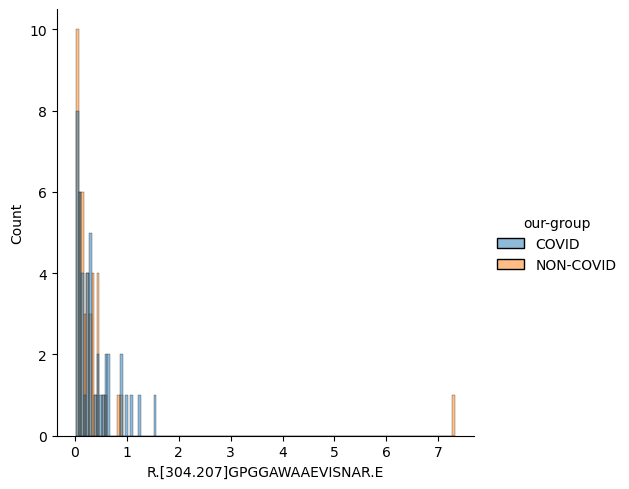

In [12]:
his_data = sns.displot(dataset_preprocessed, x='R.[304.207]GPGGAWAAEVISNAR.E', hue='our-group', binwidth=0.05)

In [13]:
# his_data.data

### 2D plot

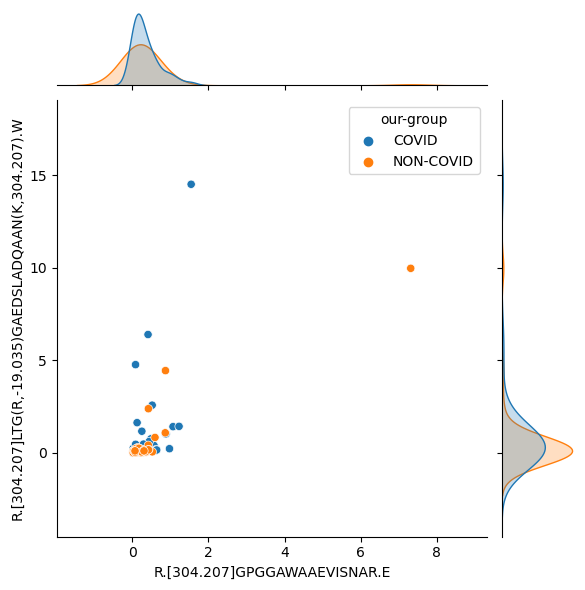

In [14]:
#use the same filtered matrix from above

sns.jointplot(x=dataset_preprocessed["R.[304.207]GPGGAWAAEVISNAR.E"],
              y=dataset_preprocessed["R.[304.207]LTG(R,-19.035)GAEDSLADQAAN(K,304.207).W"],
              hue=dataset_preprocessed['our-group'])

### Data preprocessing for heat maps

In [15]:
def z_score(df):
    # copy the dataframe
    df_std = df.copy()
    # apply the z-score method
    for column in df_std.columns:
        df_std[column] = (df_std[column] - df_std[column].mean()) / df_std[column].std()
        df_std[column] = df_std[column].map(lambda x: x if np.isnan(x) else min(3,max(-3,x)))
    return df_std

In [16]:
#make a copy of the matrix for further processing in the heatmap
dataset_preprocessed_heatmap = dataset_preprocessed.copy()
# the top 12 variants for SAA2 in COVID19
top_variants = ["R.[304.207]GPGGAWAAEVISNAR.E", "R.[304.207]LTG(R,-19.035)GAEDSLADQAAN(K,304.207).W", "A.[304.207](W,-121.748)AAEVISNAR.E", "R.[304.207](L,172.089)TGRGAEDSLADQAAN(K,304.207).W", "R.[304.207](L,285.173)TGRGAEDSLADQAAN(K,304.207).W", "R.[304.207]LTG(R,-19.032)GAEDSLADQAAN(K,304.207)WG.R", "K.[304.207]RGPGGA(W,16.001)AAEVISNAR.E", "D.[226.063]SLADQAAN(K,304.207).W", "R.{59.319}[304.207]GAEDSLADQAAN(K,304.207).W", "L.[304.207]TG(R,-19.036)GAEDSLADQAAN(K,304.207).W", "R.{60.067}[304.207]GAEDSLADQAAN(K,304.207).W", "R.[304.207]LTG(R,37.986)GAEDSLADQAAN(K,304.207).W"]
dataset_preprocessed_heatmap = dataset_preprocessed_heatmap.loc[:,list(top_variants)]
# z-score transform the peptide intensities
dataset_preprocessed_heatmap = z_score(dataset_preprocessed_heatmap)
#transpose the matrix, so we can have peptides as rows
dataset_preprocessed_heatmap = dataset_preprocessed_heatmap.T
dataset_preprocessed_heatmap

,_dyn_#Non-severe-COVID-19.Patient-group-PT,_dyn_#Non-severe-COVID-19.XG1,_dyn_#Non-severe-COVID-19.XG10,_dyn_#Non-severe-COVID-19.XG11,_dyn_#Non-severe-COVID-19.XG13,_dyn_#Non-severe-COVID-19.XG14,_dyn_#Non-severe-COVID-19.XG15,_dyn_#Non-severe-COVID-19.XG16,_dyn_#Non-severe-COVID-19.XG17,_dyn_#Non-severe-COVID-19.XG18,...,_dyn_#Symptomatic-non-COVID-19.JBDZ24,_dyn_#Symptomatic-non-COVID-19.JBDZ25,_dyn_#Symptomatic-non-COVID-19.JBDZ3,_dyn_#Symptomatic-non-COVID-19.JBDZ4,_dyn_#Symptomatic-non-COVID-19.JBDZ5,_dyn_#Symptomatic-non-COVID-19.JBDZ6,_dyn_#Symptomatic-non-COVID-19.JBDZ7,_dyn_#Symptomatic-non-COVID-19.JBDZ8,_dyn_#Symptomatic-non-COVID-19.JBDZ9,_dyn_#Symptomatic-non-COVID-19.Patient-group-jbdz
Peptide,,,,,,,,,,,,,,,,,,,,,
R.[304.207]GPGGAWAAEVISNAR.E,-0.112401,-0.164942,-0.391158,-0.437530,-0.426370,-0.279045,-0.286316,-0.174225,-0.328594,-0.238737,...,-0.009161,-0.020687,0.616018,-0.431223,-0.381947,-0.380278,-0.083003,0.064130,-0.082694,-0.377704
"R.[304.207]LTG(R,-19.035)GAEDSLADQAAN(K,304.207).W",-0.333027,-0.343899,-0.259501,-0.239384,-0.304089,-0.316274,-0.271065,-0.159562,-0.346421,-0.315402,...,-0.334097,-0.325396,0.164332,NaN,-0.311581,-0.337160,-0.287189,-0.277831,-0.305363,-0.303944
"A.[304.207](W,-121.748)AAEVISNAR.E",0.122022,NaN,-0.499085,-0.619964,-0.602590,-0.421388,-0.413957,-0.258472,-0.546678,-0.563723,...,-0.308120,-0.307245,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.418971
"R.[304.207](L,172.089)TGRGAEDSLADQAAN(K,304.207).W",-0.631992,-0.662901,NaN,NaN,NaN,-0.550407,-0.536465,-0.471712,-0.460549,-0.557464,...,NaN,NaN,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"R.[304.207](L,285.173)TGRGAEDSLADQAAN(K,304.207).W",-0.295882,-0.300998,-0.252076,-0.308775,-0.303244,-0.296331,-0.247685,-0.128815,-0.311994,-0.307223,...,-0.270069,-0.275343,-0.042284,NaN,-0.306139,-0.309972,-0.205093,-0.169992,-0.227980,-0.222015
"R.[304.207]LTG(R,-19.032)GAEDSLADQAAN(K,304.207)WG.R",0.041968,NaN,NaN,NaN,NaN,-0.303922,-0.315877,-0.157950,-0.460806,-0.449611,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.340329,-0.247640,-0.284370,-0.372542
"K.[304.207]RGPGGA(W,16.001)AAEVISNAR.E",-0.567477,-0.716445,-0.462775,-0.570834,-0.430609,NaN,NaN,NaN,NaN,NaN,...,0.287371,0.382854,0.551323,NaN,NaN,NaN,-0.435294,-0.374774,-0.489603,0.161877
"D.[226.063]SLADQAAN(K,304.207).W",-0.062826,NaN,-0.518131,-0.723469,-0.522999,-0.285933,-0.393611,-0.168953,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.389180,0.399944,0.214528,0.197281
"R.{59.319}[304.207]GAEDSLADQAAN(K,304.207).W",-0.326509,-0.336994,-0.070051,-0.290422,-0.259056,NaN,NaN,NaN,-0.292955,-0.281407,...,-0.239749,-0.228922,-0.013143,NaN,NaN,NaN,-0.315000,-0.292622,-0.309016,-0.316587


### Draw the heat map for the top 12 variants

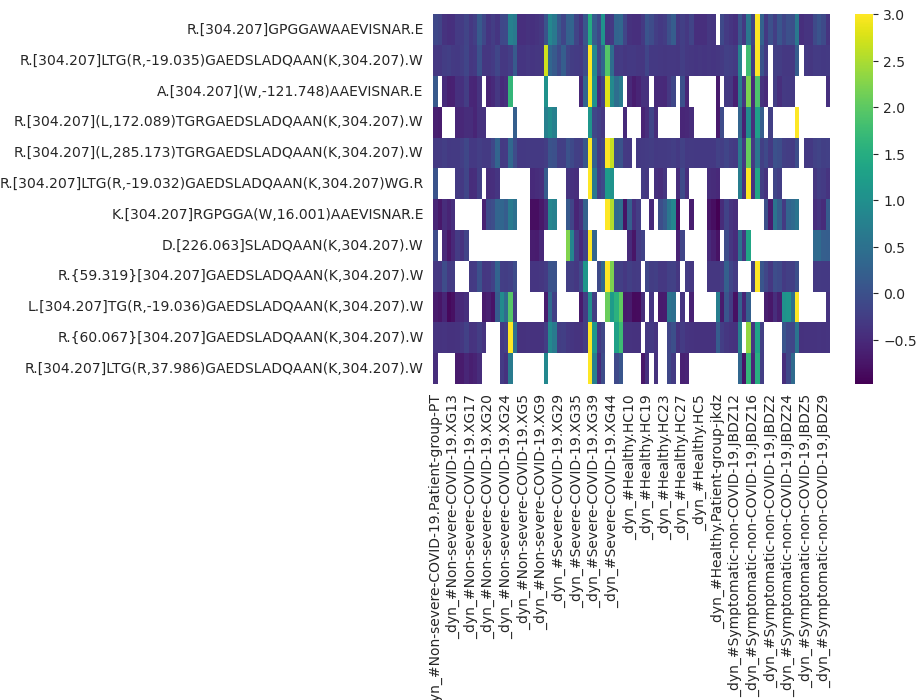

In [17]:
cmap = sns.color_palette("viridis", as_cmap=True)
with sns.axes_style("white"):
    sns.heatmap(dataset_preprocessed_heatmap, cmap=cmap)

# Statistical tests
In the code below we use two functions in scipy.stats to compute the t-test (standard/typical test for difference of means, makes Gaussian assumptions) and the Mann-Whitney rank test (non-parametric version of the test for difference of medians, does not make Gaussian assumptions) between two groups of intensities from a variant. These tests are to answer whether the means (t-test) or medians (Mann-Whitney) of the two groups are significantly different. 

Result:
Do not pass the t-test and Mann-Whitney test (value all >0.05), which means the problem we are researching is hard to classify by simple statistics. --> the problem is meaningful since it's hard for traditional methods. We intended to use machine learning methods which combine many features of data to do a comprehensive classification, so that it will still achieve a good performance.


In [18]:
covid_intensities = dataset_preprocessed["R.[304.207]GPGGAWAAEVISNAR.E"][dataset_preprocessed.label == 1].dropna()
non_covid_intensities = dataset_preprocessed["R.[304.207]GPGGAWAAEVISNAR.E"][dataset_preprocessed.label == 0].dropna()
print("T-test:", stats.ttest_ind(covid_intensities, non_covid_intensities, equal_var = False))
print("Mann-Whitney rank test:", stats.mannwhitneyu(covid_intensities, non_covid_intensities, alternative = 'two-sided'))

T-test: Ttest_indResult(statistic=-0.18048971726399027, pvalue=0.8574213044912364)
Mann-Whitney rank test: MannwhitneyuResult(statistic=1126.0, pvalue=0.26241612707812756)


# Feature Selection

## Get features with high variants

C:\Users\86157\AppData\Local\Temp\ipykernel_21016\2993857215.py:1: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  variants_with_var = variants_processed.var()


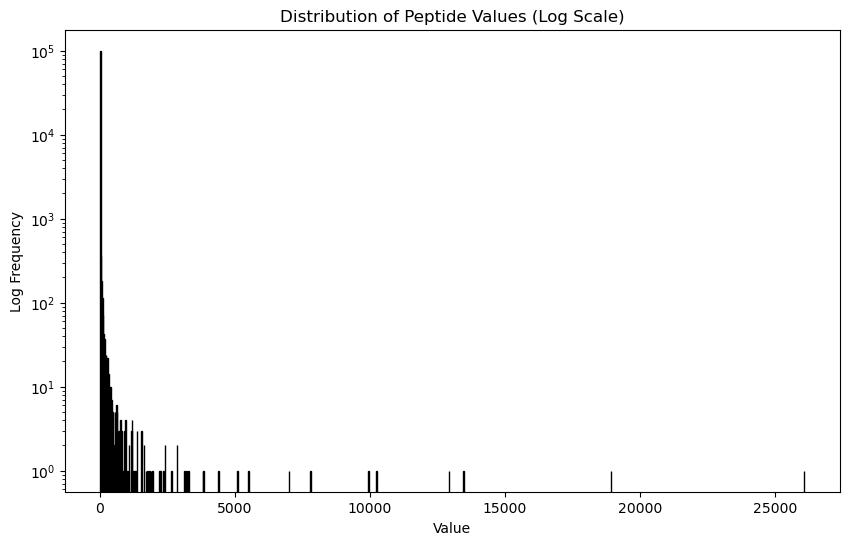

In [19]:
variants_with_var = variants_processed.var()
plt.figure(figsize=(10, 6))
plt.hist(variants_with_var, bins=1000, color='blue', edgecolor='black', log=True)
plt.title('Distribution of Peptide Values (Log Scale)')
plt.xlabel('Value')
plt.ylabel('Log Frequency')
plt.show()

### Get top 6 and do visualization

In [20]:
# variants_with_var = variants_with_var.dropna()
# percentile_99 = np.percentile(variants_with_var, 99.99)
# print("Our variants threshold is ", percentile_99)
# high_variance_features = variants_with_var[variants_with_var > percentile_99]  # keep only values higher than the 99th percentile
# high_variance_features.sort_values(ascending=False)
# top_6_peptides_names = high_variance_features.nlargest(6).index
# top_6_peptides_names

In [21]:
# top_6_peptides_data = variants_processed[top_6_peptides_names]
# corr_matrix = top_6_peptides_data.corr()

# # Generate a mask for the upper triangle (optional)
# mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# # Set up the matplotlib figure
# f, ax = plt.subplots(figsize=(11, 9))

# # Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)

# # Draw the heatmap with the mask and correct aspect ratio
# sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

# plt.show()
# corr_matrix

In [22]:
# columns_to_keep = ["K.[304.207](K,304.207)QTALVELV(K,348.165).H", 
#                    "Q.[304.207]TALVELV(K,304.207).H", 
#                    "R.[304.207](F,-57.06)(K,304.207)DLGEENF(K,304.207).A", 
#                    "R.[304.207]LASYLD(K,304.207)VR.A",
#                    "label",
#                    "our-group",
#                    "Condition"]
# dataset_preprocessed_top4 = dataset_preprocessed[columns_to_keep]

### Get top 90% as the input features for XGBoost model

In [23]:
def getFeaturesName(variants_processed, percentile = 99.9):
    variants_processed_var = variants_processed.var()
    variants_processed_var = variants_processed_var.dropna()
    percentile_99 = np.percentile(variants_processed_var, percentile)
    print("Our variants threshold is ", percentile_99)
    high_variance_features = variants_processed_var[variants_processed_var > percentile_99]  # keep only values higher than the 99th percentile
    high_variance_features.sort_values(ascending=False)
    print(high_variance_features.index)
    return high_variance_features.index.tolist()

features = getFeaturesName(variants_processed, percentile=10)

Our variants threshold is  0.04486783258015391
Index(['K.[304.207]GARLIPEMDQIFTEVEMTTLE(K,304.207).V',
       'I.[304.207]FTEVEMTTLE(K,304.207).V', 'K.[304.207]LYQPEYQEVSTEEQR.E',
       'K.[304.207]AANSLEAFIFETQD(K,304.207).L',
       'R.[304.207]YSHDF(N,-56.985)FH.I',
       'R.[304.207](P,143.096)SV(C,57.021)REAGPQAHMQQVTSSL(K,304.207).G',
       'K.[304.207]QGSTGEEFHFQTGGR.D',
       'K.[304.207]HGTDDGVVW(M,15.995)NW(K,304.207).G',
       'K.[304.207](H,100.027)GTDDGVVWMNW(K,304.207).G',
       'K.[304.207]H(G,304.213)TDDGVVWMNW(K,304.207).G',
       ...
       'K.[304.207]YLGEE(Y,-20.114)V(K,304.207).A',
       'K.[304.207]YLGEE(Y,-21.617)V(K,304.207).A',
       'K.[304.207]YLGEE(Y,-57.005)V(K,304.207).A',
       'K.[304.207]YLGEE(Y,-58.064)V(K,304.207).A',
       'K.[304.207]YLGEE(Y,-60.599)V(K,304.207).A',
       'K.[304.207]YLGE(E,-68.078)YV(K,304.207).A',
       'K.[304.207]YL(G,55.921)EEYV(K,304.207).A',
       'K.{187.018}[304.207]YLGEEYV(K,304.207).A',
       'R.[304.207]NT

C:\Users\86157\AppData\Local\Temp\ipykernel_21016\1724601701.py:2: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  variants_processed_var = variants_processed.var()


In [24]:
def getSelectedFeatues(variants_processed, features):
    columns = copy.deepcopy(features)
    columns.extend(["label", "our-group", "Condition"])
    return variants_processed[columns]

dataset_preprocessed = getSelectedFeatues(dataset_preprocessed, features)
dataset_preprocessed.shape

(90, 90849)

In [25]:
dataset_preprocessed.head()

Peptide,"K.[304.207]GARLIPEMDQIFTEVEMTTLE(K,304.207).V","I.[304.207]FTEVEMTTLE(K,304.207).V",K.[304.207]LYQPEYQEVSTEEQR.E,"K.[304.207]AANSLEAFIFETQD(K,304.207).L","R.[304.207]YSHDF(N,-56.985)FH.I","R.[304.207](P,143.096)SV(C,57.021)REAGPQAHMQQVTSSL(K,304.207).G",K.[304.207]QGSTGEEFHFQTGGR.D,"K.[304.207]HGTDDGVVW(M,15.995)NW(K,304.207).G","K.[304.207](H,100.027)GTDDGVVWMNW(K,304.207).G","K.[304.207]H(G,304.213)TDDGVVWMNW(K,304.207).G",...,"K.[304.207]YLGEE(Y,-58.064)V(K,304.207).A","K.[304.207]YLGEE(Y,-60.599)V(K,304.207).A","K.[304.207]YLGE(E,-68.078)YV(K,304.207).A","K.[304.207]YL(G,55.921)EEYV(K,304.207).A","K.{187.018}[304.207]YLGEEYV(K,304.207).A","R.[304.207]NTYE(K,361.237)YLGEEYV(K,304.207).A","K.[304.207]YLGE(E,125.898)YV(K,304.207).A",label,our-group,Condition
_dyn_#Non-severe-COVID-19.Patient-group-PT,NaN,NaN,0.678696,2.127578,NaN,NaN,NaN,NaN,NaN,0.334896,...,1.915291,2.343374,NaN,NaN,NaN,0.964770,NaN,1,COVID,_dyn_#Non-severe-COVID-19
_dyn_#Non-severe-COVID-19.XG1,NaN,NaN,0.743318,NaN,NaN,NaN,NaN,NaN,NaN,0.278907,...,NaN,NaN,NaN,NaN,NaN,0.163054,NaN,1,COVID,_dyn_#Non-severe-COVID-19
_dyn_#Non-severe-COVID-19.XG10,2.696391,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.021225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,COVID,_dyn_#Non-severe-COVID-19
_dyn_#Non-severe-COVID-19.XG11,2.208365,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017387,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,COVID,_dyn_#Non-severe-COVID-19
_dyn_#Non-severe-COVID-19.XG13,3.721901,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.019735,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,COVID,_dyn_#Non-severe-COVID-19


# Model
Among these models, we select Extreme Gradient Boosting (XGBoost) and Random Forest as our benchmark models, and choose Logistic Regression as our baseline model. 


### Special character handling

Reason: In XGBoost model, feature names must be string, and may not contain [,] or <

In [26]:
def handle_special_character(s):
    return s.replace("[",'#').replace("]","#").replace("<","#")

dataset_preprocessed.columns= dataset_preprocessed.columns.str.replace("[",'#')
dataset_preprocessed.columns= dataset_preprocessed.columns.str.replace("]",'#')
dataset_preprocessed.columns= dataset_preprocessed.columns.str.replace("<",'#')


C:\Users\86157\AppData\Local\Temp\ipykernel_21016\451269.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataset_preprocessed.columns= dataset_preprocessed.columns.str.replace("[",'#')
C:\Users\86157\AppData\Local\Temp\ipykernel_21016\451269.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  dataset_preprocessed.columns= dataset_preprocessed.columns.str.replace("]",'#')


In [27]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from mpl_toolkits import mplot3d
from sklearn import linear_model
from sklearn import ensemble
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

### Dataset construction
1. randomize the dataset
2. train, val, test split

In [28]:
# randomize the dataset
dataset_preprocessed_random = dataset_preprocessed.sample(frac=1, random_state=0)
X_raw = dataset_preprocessed_random.drop(["label", "our-group", "Condition"], axis=1)
Y_raw = dataset_preprocessed_random["label"]

In [29]:
# train, val, test split
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1

N = len(X_raw)
X_train = X_raw[:int(N*TRAIN_SIZE)]
Y_train = Y_raw[:int(N*TRAIN_SIZE)]
X_val = X_raw[int(N*TRAIN_SIZE): int(N*(TRAIN_SIZE+VAL_SIZE))]
Y_val = Y_raw[int(N*TRAIN_SIZE): int(N*(TRAIN_SIZE+VAL_SIZE))]
X_test = X_raw[int(N*(TRAIN_SIZE+VAL_SIZE)):]
Y_test = Y_raw[int(N*(TRAIN_SIZE+VAL_SIZE)):]

print("train,val,test dataset size:", X_train.shape, X_val.shape, X_test.shape)

train,val,test dataset size: (72, 90846) (9, 90846) (9, 90846)


### Missing Value handling
Reason:
LogisticRegression does not accept missing values encoded as NaN natively.

Try two methods:
1. fill the missing value with 0
2. fill the missing value with mean value --> Note: we need to calculate mean separately, so that the information in the training set won't leak into the validation and testing processes.Here we use a tool to complete missing values with simple strategies. https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html

In [30]:
X_train.isna().sum(axis = 0)

Peptide
K.#304.207#GARLIPEMDQIFTEVEMTTLE(K,304.207).V     64
I.#304.207#FTEVEMTTLE(K,304.207).V                60
K.#304.207#LYQPEYQEVSTEEQR.E                      27
K.#304.207#AANSLEAFIFETQD(K,304.207).L            56
R.#304.207#YSHDF(N,-56.985)FH.I                   54
                                                  ..
K.#304.207#YLGE(E,-68.078)YV(K,304.207).A         52
K.#304.207#YL(G,55.921)EEYV(K,304.207).A          52
K.{187.018}#304.207#YLGEEYV(K,304.207).A          54
R.#304.207#NTYE(K,361.237)YLGEEYV(K,304.207).A    47
K.#304.207#YLGE(E,125.898)YV(K,304.207).A         53
Length: 90846, dtype: int64

In [31]:
from sklearn.impute import SimpleImputer

fillna_method = 1

if fillna_method == 1:
    # Method 1
    X_train = X_train.fillna(0)
    X_val = X_val.fillna(0)
    X_test = X_test.fillna(0)
else:
    # Method 2
    my_imputer = SimpleImputer(strategy = 'mean')

    X_train = my_imputer.fit_transform(X_train)
    X_val = my_imputer.transform(X_val)
    X_test = my_imputer.transform(X_test)
    
print("Training data:", X_train.shape)
print("Val data:", X_val.shape)
print("Test data:", X_test.shape)

Training data: (72, 90846)
Val data: (9, 90846)
Test data: (9, 90846)


### Metrics
- False Positive, False Negative, True Positive, True Negative
- Precision
- Recall
- Accuracy or Balanced accuracy
- F1 Score
- ROC curve and Area under the ROC curve (AUC)


In [32]:
def getMetrics(predictions, y, flag_print= False):
    TP = sum([(p and l) for (p, l) in zip(predictions, y)])
    FP = sum([(p and not l) for (p, l) in zip(predictions, y)])
    TN = sum([(not p and not l) for (p, l) in zip(predictions, y)])
    FN = sum([(not p and l) for (p, l) in zip(predictions, y)])
    
    # Precision 
    Precision = TP / (TP + FP)

    # Recall or Sensitivity
    Recall = TP / (TP + FN)

    # Accuracy
    Accuracy = (TP + TN) / (TP + FP + TN + FN)

    # Balanced Accuracy
    Balanced_accuracy = (Recall + TN / (TN + FP)) / 2

    # F1 Score
    F1_Score = 2*(Precision * Recall) / (Precision + Recall)
    
    if flag_print:
        print("Precision: ", Precision)
        print("Recall: ", Recall)
        print("Accuracy: ", Accuracy)
        print("Balanced Accuracy: ", Balanced_accuracy)
        print("F1 Score: ", F1_Score)
    
    return Precision, Recall, Accuracy, Balanced_accuracy, F1_Score

### Logistic regression

HP tuning: tune HP C
random_state=1

4 feature:
```
Logistic Regression Classifier best acc: 0.66 bestC: 0.0001
Logistic Regression Classifier performance:
Precision:  0.75
Recall:  0.6
Accuracy:  0.66
Balanced Accuracy:  0.675
F1 Score:  0.66
```

100 feature:
```
Logistic Regression Classifier best acc: 0.8888888888888888 bestC: 0.0001
Logistic Regression Classifier performance:
Precision:  1.0
Recall:  0.6
Accuracy:  0.7777777777777778
Balanced Accuracy:  0.8
F1 Score:  0.7499999999999999
```

90846 feature:

```
Logistic Regression Classifier best acc: 0.8888888888888888 bestC: 0.001
Logistic Regression Classifier performance:
Precision:  1.0
Recall:  1.0
Accuracy:  1.0
Balanced Accuracy:  1.0
F1 Score:  1.0
```


In [41]:
Y_val

_dyn_#Symptomatic-non-COVID-19.JBDZ16     0
_dyn_#Severe-COVID-19.Patient-group-ZX    1
_dyn_#Severe-COVID-19.XG40                1
_dyn_#Healthy.HC13                        0
_dyn_#Severe-COVID-19.XG43                1
_dyn_#Symptomatic-non-COVID-19.JBDZ1      0
_dyn_#Healthy.HC3                         0
_dyn_#Non-severe-COVID-19.XG20            1
_dyn_#Symptomatic-non-COVID-19.JBDZ14     0
Name: label, dtype: int64

In [32]:
acc_list = []
C_list = [10 ** i for i in range(-4, 2, 1)]
for C in C_list:
    model = linear_model.LogisticRegression(C=C, class_weight='balanced')
    model.fit(X_train, Y_train)
    preds = model.predict(X_val)
    Precision, Recall, Accuracy, Balanced_accuracy, F1_Score = getMetrics(preds, Y_val, flag_print=False)
    acc_list.append(Accuracy)

idx = acc_list.index(max(acc_list))
bestC = C_list[idx]
acc4 = acc_list[idx]
print("Logistic Regression Classifier best acc:", acc4, "bestC:", bestC)

# classifier based method
model = linear_model.LogisticRegression(C=bestC, class_weight='balanced')
model.fit(X_train, Y_train)

preds = model.predict(X_test)
print("Logistic Regression Classifier performance:")
Precision, Recall, Accuracy, Balanced_accuracy, F1_Score = getMetrics(preds, Y_test, flag_print=True)

Logistic Regression Classifier best acc: 0.8888888888888888 bestC: 0.001
Logistic Regression Classifier performance:
Precision:  1.0
Recall:  1.0
Accuracy:  1.0
Balanced Accuracy:  1.0
F1 Score:  1.0


### Random Forest

Best Parameters:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}

4 feature:
```
Random Forest Classifier best acc: 0.6666666666666666 bestC: 150
Random Forest Model performance:
Precision:  0.6666666666666666
Recall:  0.4
Accuracy:  0.5555555555555556
Balanced Accuracy:  0.575
F1 Score:  0.5
```

100 feature:
```
Random Forest Classifier best acc: 0.8888888888888888 bestC: 150
Random Forest Model performance:
Precision:  0.6
Recall:  0.6
Accuracy:  0.5555555555555556
Balanced Accuracy:  0.55
F1 Score:  0.6

```

90846 feature:

```
[[4 2]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.60      1.00      0.75         3

    accuracy                           0.78         9
   macro avg       0.80      0.83      0.77         9
weighted avg       0.87      0.78      0.78         9

0.7777777777777778
Random Forest Model performance:
Precision:  0.6
Recall:  1.0
Accuracy:  0.7777777777777778
Balanced Accuracy:  0.8333333333333333
F1 Score:  0.7499999999999999
```


In [56]:
# Initialize the RandomForestClassifier
rf = ensemble.RandomForestClassifier()

# Create the parameter grid
param_grid = { 
    'n_estimators': [100, 200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(np.concatenate((X_train,X_val)), np.concatenate((Y_train,Y_val)))

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesC

D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesC

D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesC

D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesC

D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesC

D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesC

Best Parameters:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}


In [70]:
# further search for max depth

# Initialize the RandomForestClassifier
rf = ensemble.RandomForestClassifier()

# Create the parameter grid
param_grid = { 
    'n_estimators': [100],
    'max_features': ['sqrt'],
    'max_depth' : [int(x) for x in np.linspace(3, 20, num = 11)],
    'criterion' :['entropy']
}
# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(np.concatenate((X_train,X_val)), np.concatenate((Y_train,Y_val)))

# Print the best parameters
print("Best Parameters: ", grid_search.best_params_)

Best Parameters:  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100}


In [71]:
# verify on test set
Depth_list = [i*1 for i in range(4,10)]
for depth in Depth_list:
    print("depth:", depth)
    # Train and predict with the best parameters
    rf_best = ensemble.RandomForestClassifier(n_estimators=grid_search.best_params_['n_estimators'], 
                                     max_features=grid_search.best_params_['max_features'],
                                     max_depth=depth, 
                                     criterion=grid_search.best_params_['criterion'])
    rf_best.fit(np.concatenate((X_train,X_val)), np.concatenate((Y_train,Y_val)))
    predictions = rf_best.predict(X_test)

    print(confusion_matrix(Y_test, predictions))
    print(classification_report(Y_test, predictions))
    print(accuracy_score(Y_test, predictions))
    print("Random Forest Model performance:")
    Precision, Recall, Accuracy, Balanced_accuracy, F1_Score = getMetrics(predictions, Y_test, flag_print=True)

depth: 4


D:\anaconda\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[[4 2]
 [1 2]]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.50      0.67      0.57         3

    accuracy                           0.67         9
   macro avg       0.65      0.67      0.65         9
weighted avg       0.70      0.67      0.68         9

0.6666666666666666
Random Forest Model performance:
Precision:  0.5
Recall:  0.6666666666666666
Accuracy:  0.6666666666666666
Balanced Accuracy:  0.6666666666666666
F1 Score:  0.5714285714285715
depth: 5


D:\anaconda\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[[4 2]
 [1 2]]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.50      0.67      0.57         3

    accuracy                           0.67         9
   macro avg       0.65      0.67      0.65         9
weighted avg       0.70      0.67      0.68         9

0.6666666666666666
Random Forest Model performance:
Precision:  0.5
Recall:  0.6666666666666666
Accuracy:  0.6666666666666666
Balanced Accuracy:  0.6666666666666666
F1 Score:  0.5714285714285715
depth: 6


D:\anaconda\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[[3 3]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      0.50      0.67         6
           1       0.50      1.00      0.67         3

    accuracy                           0.67         9
   macro avg       0.75      0.75      0.67         9
weighted avg       0.83      0.67      0.67         9

0.6666666666666666
Random Forest Model performance:
Precision:  0.5
Recall:  1.0
Accuracy:  0.6666666666666666
Balanced Accuracy:  0.75
F1 Score:  0.6666666666666666
depth: 7


D:\anaconda\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[[4 2]
 [1 2]]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.50      0.67      0.57         3

    accuracy                           0.67         9
   macro avg       0.65      0.67      0.65         9
weighted avg       0.70      0.67      0.68         9

0.6666666666666666
Random Forest Model performance:
Precision:  0.5
Recall:  0.6666666666666666
Accuracy:  0.6666666666666666
Balanced Accuracy:  0.6666666666666666
F1 Score:  0.5714285714285715
depth: 8


D:\anaconda\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[[4 2]
 [0 3]]
              precision    recall  f1-score   support

           0       1.00      0.67      0.80         6
           1       0.60      1.00      0.75         3

    accuracy                           0.78         9
   macro avg       0.80      0.83      0.77         9
weighted avg       0.87      0.78      0.78         9

0.7777777777777778
Random Forest Model performance:
Precision:  0.6
Recall:  1.0
Accuracy:  0.7777777777777778
Balanced Accuracy:  0.8333333333333333
F1 Score:  0.7499999999999999
depth: 9


D:\anaconda\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


[[4 2]
 [1 2]]
              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.50      0.67      0.57         3

    accuracy                           0.67         9
   macro avg       0.65      0.67      0.65         9
weighted avg       0.70      0.67      0.68         9

0.6666666666666666
Random Forest Model performance:
Precision:  0.5
Recall:  0.6666666666666666
Accuracy:  0.6666666666666666
Balanced Accuracy:  0.6666666666666666
F1 Score:  0.5714285714285715


# XGBoost

4 feature:
```
XGBoost Model (before fine tune) test results:
Precision:  0.6666666666666666
Recall:  0.4
Accuracy:  0.5555555555555556
Balanced Accuracy:  0.575
F1 Score:  0.5

XGBoost Model (fine-tuned) results:
Precision:  0.6666666666666666
Recall:  0.4
Accuracy:  0.5555555555555556
Balanced Accuracy:  0.575
F1 Score:  0.5

```
90846 feature:
```
XGBoost Model (fine-tuned) results:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.75      1.00      0.86         3

    accuracy                           0.89         9
   macro avg       0.88      0.92      0.88         9
weighted avg       0.92      0.89      0.89         9

Precision:  0.75
Recall:  1.0
Accuracy:  0.8888888888888888
Balanced Accuracy:  0.9166666666666667
F1 Score:  0.8571428571428571


```

In [34]:
# XGBoost model
xgb_random_seed = 42

xgb_model_raw = xgb.XGBClassifier(seed=xgb_random_seed)
xgb_model_raw.fit(X_train, Y_train)
pred_xgb = xgb_model_raw.predict(X_test)
print("XGBoost Model (before fine tune) test results:")
Precision, Recall, Accuracy, Balanced_accuracy, F1_Score = getMetrics(pred_xgb, Y_test, flag_print=True)

XGBoost Model (before fine tune) test results:
Precision:  0.75
Recall:  1.0
Accuracy:  0.8888888888888888
Balanced Accuracy:  0.9166666666666667
F1 Score:  0.8571428571428571


### Fine-tuning of XGBoost Model

XGB version: 1.7.4
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7}
Highest accuracy:  0.938109756097561


training logs:
```
[CV 1/2] END colsample_bylevel=0.4, colsample_bytree=0.5, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.6;, score=0.951 total time=   5.9
s
[CV 2/2] END colsample_bylevel=0.4, colsample_bytree=0.5, learning_rate=0.3, max_depth=8, n_estimators=50, subsample=0.6;, score=0.825 total time=   6.3
s
[CV 1/2] END colsample_bylevel=0.7, colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.6;, score=0.951 total time=   6.8
s
[CV 2/2] END colsample_bylevel=0.7, colsample_bytree=0.4, learning_rate=0.1, max_depth=8, n_estimators=50, subsample=0.6;, score=0.925 total time=   7.4
s
[CV 2/2] END colsample_bylevel=0.7, colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.6;, score=0.850 total time=   8.7
s
[CV 2/2] END colsample_bylevel=0.7, colsample_bytree=0.8999999999999999, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.8999999999999999;,
 score=0.850 total time=   9.0s
[CV 1/2] END colsample_bylevel=0.7, colsample_bytree=0.7, learning_rate=0.2, max_depth=7, n_estimators=50, subsample=0.6;, score=0.829 total time=   9.1
s
[CV 1/2] END colsample_bylevel=0.4, colsample_bytree=0.7, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.5;, score=0.878 total time=  11.
5s
[CV 1/2] END colsample_bylevel=0.7, colsample_bytree=0.8999999999999999, learning_rate=0.3, max_depth=7, n_estimators=50, subsample=0.8999999999999999;,
 score=0.854 total time=  11.9s
[CV 2/2] END colsample_bylevel=0.4, colsample_bytree=0.7, learning_rate=0.2, max_depth=6, n_estimators=100, subsample=0.5;, score=0.775 total time=  12.
4s
[CV 2/2] END colsample_bylevel=0.7, colsample_bytree=0.7999999999999999, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=0.5;, score=0.925 t
otal time=  16.7s
[CV 1/2] END colsample_bylevel=0.7, colsample_bytree=0.7999999999999999, learning_rate=0.1, max_depth=8, n_estimators=100, subsample=0.5;, score=0.805 t
otal time=  17.1s
[CV 1/2] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.4, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.5;, score=0.829 t
otal time=  17.4s
[CV 2/2] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.4, learning_rate=0.1, max_depth=5, n_estimators=150, subsample=0.5;, score=0.900 t
otal time=  17.4s
[CV 2/2] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=150, subsample=0.5;, score=0.850
total time=  22.3s
[CV 1/2] END colsample_bylevel=0.7999999999999999, colsample_bytree=0.6, learning_rate=0.01, max_depth=6, n_estimators=150, subsample=0.5;, score=0.878
total time=  22.3s
[CV 1/2] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.7999999999999999, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;
, score=0.854 total time=  15.9s
[CV 2/2] END colsample_bylevel=0.8999999999999999, colsample_bytree=0.7999999999999999, learning_rate=0.2, max_depth=7, n_estimators=150, subsample=0.7;
, score=0.875 total time=  15.2s
[CV 1/2] END colsample_bylevel=0.7, colsample_bytree=0.8999999999999999, learning_rate=0.01, max_depth=8, n_estimators=150, subsample=0.7999999999999999
;, score=0.829 total time=  24.0s
[CV 2/2] END colsample_bylevel=0.7, colsample_bytree=0.8999999999999999, learning_rate=0.01, max_depth=8, n_estimators=150, subsample=0.7999999999999999
;, score=0.850 total time=  23.8s

```

In [37]:
# fine-tuning, using f1 score: https://scikit-learn.org/stable/modules/model_evaluation.html
print("XGB version:",xgb.__version__)
params = { 'max_depth': [5, 6, 7, 8],
           'learning_rate': [0.01, 0.1, 0.2, 0.3],
           'subsample': np.arange(0.5, 1.0, 0.1),
           'colsample_bytree': np.arange(0.4, 1.0, 0.1),
           'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
           'n_estimators': [50, 100, 150]}
xgbr = xgb.XGBClassifier(seed = xgb_random_seed)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='accuracy',
                         n_iter=10, # number of samples in random selection
                         cv = 2, # 2 fold cross validation
                         n_jobs=-1,   # use all processor
                         random_state= xgb_random_seed, # set the seed 
                         verbose=4)
clf.fit(np.concatenate((X_train, X_val)), np.concatenate((Y_train, Y_val)))
print("Best parameters:", clf.best_params_)
print("Highest accuracy: ", clf.best_score_)

XGB version: 1.7.4
Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7}
Highest accuracy:  0.938109756097561


In [40]:
# further search for max depth
params = { 'max_depth': [i*1 for i in range(3,10)],
           'learning_rate': [0.1],
           'subsample': [0.6],
           'colsample_bytree': [0.4],
           'colsample_bylevel': [0.7],
           'n_estimators': [50]}
xgbr = xgb.XGBClassifier(seed = xgb_random_seed)
clf = RandomizedSearchCV(estimator=xgbr,
                         param_distributions=params,
                         scoring='accuracy',
                         n_iter=10, # number of samples in random selection
                         cv = 5, # 5 fold cross validation
                         n_jobs=-1,   # use all processor
                         random_state= xgb_random_seed, # set the seed 
                         verbose=4)
clf.fit(np.concatenate((X_train, X_val)), np.concatenate((Y_train, Y_val)))
print("Best parameters:", clf.best_params_)
print("Highest accuracy: ", clf.best_score_)

D:\anaconda\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 7 is smaller than n_iter=10. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 7 candidates, totalling 35 fits
Best parameters: {'subsample': 0.6, 'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 0.4, 'colsample_bylevel': 0.7}
Highest accuracy:  0.9132352941176471


In [43]:
# XGBoost after find-tuning
xgb_model = xgb.XGBClassifier(subsample= clf.best_params_['subsample'], 
                              n_estimators= clf.best_params_['n_estimators'], 
                              max_depth=clf.best_params_['max_depth'],
                             learning_rate=clf.best_params_['learning_rate'] , 
                              colsample_bytree= clf.best_params_['colsample_bytree'], 
                              colsample_bylevel= clf.best_params_['colsample_bylevel'])
xgb_model.fit(np.concatenate((X_train, X_val)), np.concatenate((Y_train, Y_val)))
pred_xgb = xgb_model.predict(X_test)

print("XGBoost Model (fine-tuned) results:")
print(classification_report(Y_test, pred_xgb))
Precision, Recall, Accuracy, Balanced_accuracy, F1_Score = getMetrics(pred_xgb, Y_test, flag_print=True)

XGBoost Model (fine-tuned) results:
              precision    recall  f1-score   support

           0       1.00      0.83      0.91         6
           1       0.75      1.00      0.86         3

    accuracy                           0.89         9
   macro avg       0.88      0.92      0.88         9
weighted avg       0.92      0.89      0.89         9

Precision:  0.75
Recall:  1.0
Accuracy:  0.8888888888888888
Balanced Accuracy:  0.9166666666666667
F1 Score:  0.8571428571428571


## Assessment 1: on important features for the classification

- Show a list of top features selected by your feature importance methods or from the classification model(s)
- Evaluate how well each important feature (or groups of features) correlate to the classes 
- Show supporting evidence supporting your evaluation of the quality of the selected important features (e.g. heat map(s) of the feature intensities across patients, intensity histogram between the classification classes)


In [40]:
xgb_model.feature_importances_

array([0.        , 0.        , 0.        , 0.0173002 , 0.17969947,
       0.        , 0.01582197, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.04435083, 0.        , 0.01893496, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.06391069, 0.        , 0.        , 0.02989538, 0.        ,
       0.        , 0.        , 0.02252385, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.05571595,
       0.        , 0.02440538, 0.        , 0.        , 0.        ,
       0.06923053, 0.        , 0.        , 0.        , 0.        ,
       0.04563693, 0.00838884, 0.018195  , 0.03037611, 0.00187577,
       0.02516059, 0.01510643, 0.        , 0.00723066, 0.        ,
       0.00855234, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.03846125, 0.        , 0.05543471, 0.06382

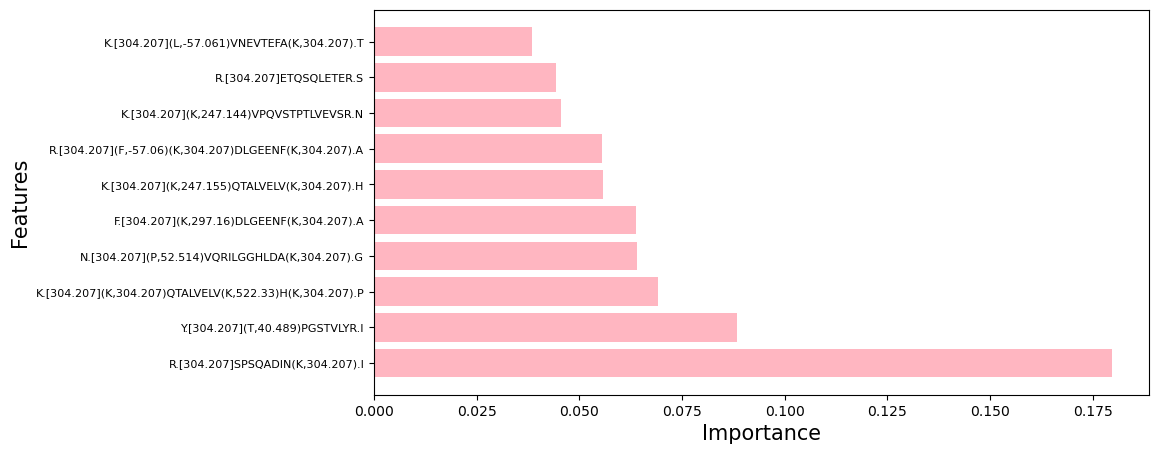

In [41]:
# get feature importance
feature_number = 10   # adjust the display feature num here
feature_names = features
sorted_idx = np.argsort(xgb_model.feature_importances_)[::-1]

plt.figure(figsize=(10,5))
plt.barh(np.array(feature_names)[sorted_idx][:feature_number],np.array(xgb_model.feature_importances_)[sorted_idx][:feature_number], color='lightpink')
plt.xlabel("Importance", fontdict={'fontsize':15})
plt.ylabel("Features", fontdict={'fontsize':15})
plt.yticks(fontsize = 8,rotation=0)
plt.savefig("./figures/feature_importance.png",dpi=300, bbox_inches = 'tight', pad_inches = 0)
plt.show()

### Evaluate how well each important feature (or groups of features) correlate to the classes

In [48]:
topk_peptides = np.array(feature_names)[sorted_idx][:feature_number]
topk_peptides

array(['R.[304.207]SPSQADIN(K,304.207).I',
       'Y.[304.207](T,40.489)PGSTVLYR.I',
       'K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P',
       'N.[304.207](P,52.514)VQRILGGHLDA(K,304.207).G',
       'F.[304.207](K,297.16)DLGEENF(K,304.207).A',
       'K.[304.207](K,247.155)QTALVELV(K,304.207).H',
       'R.[304.207](F,-57.06)(K,304.207)DLGEENF(K,304.207).A',
       'K.[304.207](K,247.144)VPQVSTPTLVEVSR.N',
       'R.[304.207]ETQSQLETER.S',
       'K.[304.207](L,-57.061)VNEVTEFA(K,304.207).T'], dtype='<U87')

In [49]:
topk_importance = np.array(xgb_model.feature_importances_)[sorted_idx][:feature_number]
topk_importance

array([0.17969947, 0.08836959, 0.06923053, 0.06391069, 0.06382184,
       0.05571595, 0.05543471, 0.04563693, 0.04435083, 0.03846125],
      dtype=float32)

In [50]:
# get top k features
topk_features = pd.DataFrame({
    'peptide': topk_peptides,
    'importance': topk_importance
})

C:\Users\86157\AppData\Local\Temp\ipykernel_5672\1960853500.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = variants_processed[topk_peptides.tolist() + ['Condition']].corr()


<Axes: xlabel='Peptide', ylabel='Peptide'>

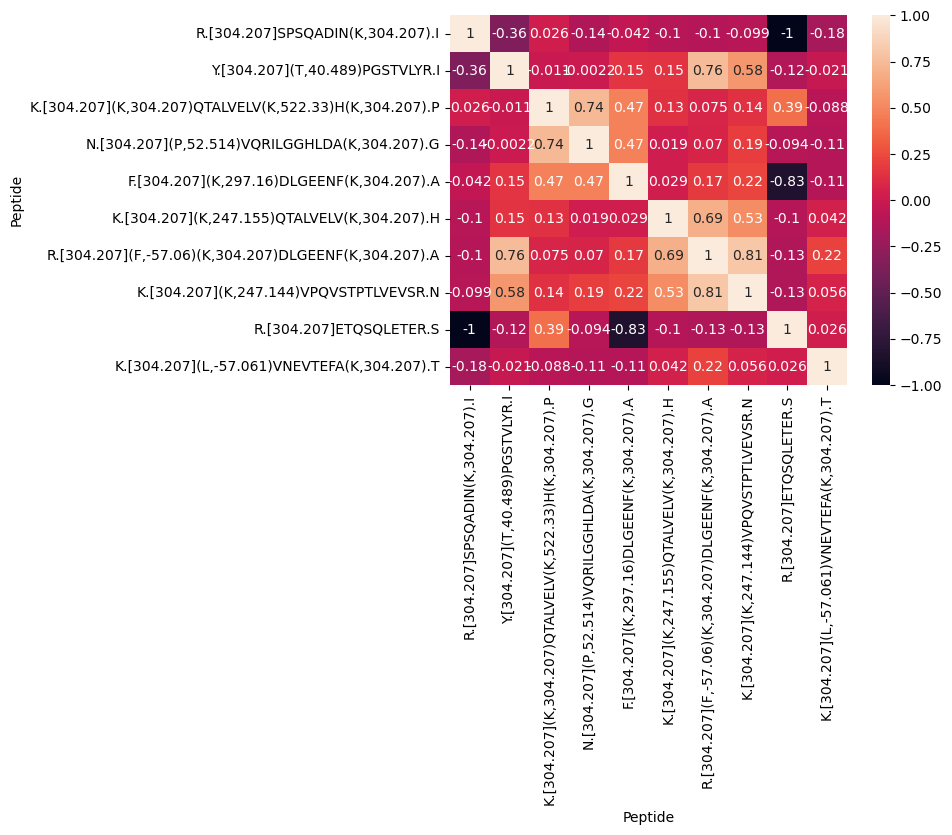

In [51]:
# Calculate the correlation among peptides
corr_matrix = variants_processed[topk_peptides.tolist() + ['Condition']].corr()
sns.heatmap(corr_matrix, annot=True)

### Show supporting evidence supporting your evaluation of the quality of the selected important features

In [53]:
encoder = OneHotEncoder(sparse=False)
target_encoded = encoder.fit_transform(variants_processed['Condition'].values.reshape(-1, 1))
target_df = pd.DataFrame(target_encoded, columns=encoder.categories_[0], index=variants_processed.index)

D:\anaconda\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [54]:
concat_df = pd.concat([variants_processed[topk_peptides], target_df], axis=1)
corr_matrix = concat_df.corr()
corr_matrix_filtered = corr_matrix.loc[topk_peptides, encoder.categories_[0]]
corr_matrix_filtered

,_dyn_#Empty,_dyn_#Healthy,_dyn_#Non-severe-COVID-19,_dyn_#Norm,_dyn_#Severe-COVID-19,_dyn_#Symptomatic-non-COVID-19
"R.[304.207]SPSQADIN(K,304.207).I",-0.054420,-0.000358,-0.150935,-0.059345,0.410520,-0.172184
"Y.[304.207](T,40.489)PGSTVLYR.I",-0.019837,-0.082234,0.256518,-0.020039,-0.083710,-0.110565
"K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P",NaN,-0.435757,0.472856,-0.096241,0.256406,-0.251796
"N.[304.207](P,52.514)VQRILGGHLDA(K,304.207).G",-0.082981,-0.355232,0.220348,-0.081645,0.400751,-0.201455
"F.[304.207](K,297.16)DLGEENF(K,304.207).A",-0.095708,-0.389533,0.566488,-0.101019,0.134395,-0.236804
"K.[304.207](K,247.155)QTALVELV(K,304.207).H",-0.039478,-0.142940,0.392454,-0.038492,-0.042581,-0.191131
"R.[304.207](F,-57.06)(K,304.207)DLGEENF(K,304.207).A",-0.031382,-0.137852,0.397662,-0.036093,-0.035166,-0.207785
"K.[304.207](K,247.144)VPQVSTPTLVEVSR.N",-0.040875,-0.147100,0.396063,-0.038979,-0.025496,-0.203093
R.[304.207]ETQSQLETER.S,-0.095128,-0.111983,-0.177255,-0.093039,-0.156129,0.548287
"K.[304.207](L,-57.061)VNEVTEFA(K,304.207).T",-0.014741,-0.074742,0.212223,-0.016710,-0.036346,-0.099141


## Assessment 2: on peptide/variant identification

R1: Show evidence to confirm the spectrum identification for the top features (at least 3) is correct (e.g. by showing the annotated peaks, similar patterns of peaks or cosine similarity with the reference spectra)

R2: For at least the top 3 modified peptide variants, show the relation to the unmodified spectra (e.g. by showing the peak patterns, cosine similarity between the modified and unmodified spectra)

Website: https://massive.ucsd.edu/ProteoSAFe/usi.jsp?#%7B%22usi%22%3A%22mzspec%3AMassIVE%3ATASK-d6178bdd5ac249d584e5cb00238130d6-spectra%2Fspecs_ms.mgf%3Ascan%3A899759%3A%5B%2B304.207%5D-SLHTLFGDK%5B%2B330.707%5DLC%5B%2B57.021%5DTVA%2F3%22%7D

Input the peptide and you will get the result.

Top 5 peptide:
1. 'R.[304.207]SPSQADIN(K,304.207).I',
2. 'Y.[304.207](T,40.489)PGSTVLYR.I',
3. 'K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P',
4. 'N.[304.207](P,52.514)VQRILGGHLDA(K,304.207).G',
5. 'F.[304.207](K,297.16)DLGEENF(K,304.207).A',


![alt text](images/top1.jpg)

![alt text](images/top2.jpg)

![alt text](images/top3.jpg)

![alt text](images/top4.jpg)

![alt text](images/top5.jpg)


## Assessment 3: on protein identification

Website: https://proteomics2.ucsd.edu/ProteoSAFe/result.jsp?task=d6178bdd5ac249d584e5cb00238130d6&view=identified_clusters

In column Peptide-Spectrum Match (PSM), input our target peptide, then search. Retrieve the value in Protein column.


Top 5 peptide:
1. 'R.[304.207]SPSQADIN(K,304.207).I', sp|P04114|APOB_HUMAN; tr|A8MUN2|A8MUN2_HUMAN
2. 'Y.[304.207](T,40.489)PGSTVLYR.I',  sp|P01024|CO3_HUMAN
3. 'K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P',  sp|P02768-2|ALBU_HUMAN; sp|P02768-3|ALBU_HUMAN; sp|P02768|ALBU_HUMAN; tr|A0A087WWT3|A0A087WWT3_HUMAN; tr|A0A0C4DGB6|A0A0C4DGB6_HUMAN; tr|B7WNR0|B7WNR0_HUMAN; tr|C9JKR2|C9JKR2_HUMAN; tr|D6RHD5|D6RHD5_HUMAN; tr|H0YA55|H0YA55_HUMAN
4. 'N.[304.207](P,52.514)VQRILGGHLDA(K,304.207).G', sp|P00738-2|HPT_HUMAN; sp|P00738|HPT_HUMAN; sp|P00739-2|HPTR_HUMAN; sp|P00739|HPTR_HUMAN; tr|A0A087WU08|A0A087WU08_HUMAN; tr|A0A0A0MRD9|A0A0A0MRD9_HUMAN; tr|A0A0C4DGL8|A0A0C4DGL8_HUMAN; tr|H0Y300|H0Y300_HUMAN; tr|J3QR68|J3QR68_HUMAN
5. 'F.[304.207](K,297.16)DLGEENF(K,304.207).A',  sp|P02768-2|ALBU_HUMAN; sp|P02768-3|ALBU_HUMAN; sp|P02768|ALBU_HUMAN; tr|A0A087WWT3|A0A087WWT3_HUMAN; tr|A0A0C4DGB6|A0A0C4DGB6_HUMAN; tr|B7WNR0|B7WNR0_HUMAN; tr|C9JKR2|C9JKR2_HUMAN; tr|H7C013|H7C013_HUMAN

In [56]:
topk_peptides = ['R.[304.207]SPSQADIN(K,304.207).I',
       'Y.[304.207](T,40.489)PGSTVLYR.I',
       'K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P',
       'N.[304.207](P,52.514)VQRILGGHLDA(K,304.207).G',
       'F.[304.207](K,297.16)DLGEENF(K,304.207).A']

topk_proteins = [
    'sp|P04114|APOB_HUMAN; tr|A8MUN2|A8MUN2_HUMAN',
    'sp|P01024|CO3_HUMAN',
    'sp|P02768-2|ALBU_HUMAN; sp|P02768-3|ALBU_HUMAN; sp|P02768|ALBU_HUMAN; tr|A0A087WWT3|A0A087WWT3_HUMAN; tr|A0A0C4DGB6|A0A0C4DGB6_HUMAN; tr|B7WNR0|B7WNR0_HUMAN; tr|C9JKR2|C9JKR2_HUMAN; tr|D6RHD5|D6RHD5_HUMAN; tr|H0YA55|H0YA55_HUMAN',
    'sp|P00738-2|HPT_HUMAN; sp|P00738|HPT_HUMAN; sp|P00739-2|HPTR_HUMAN; sp|P00739|HPTR_HUMAN; tr|A0A087WU08|A0A087WU08_HUMAN; tr|A0A0A0MRD9|A0A0A0MRD9_HUMAN; tr|A0A0C4DGL8|A0A0C4DGL8_HUMAN; tr|H0Y300|H0Y300_HUMAN; tr|J3QR68|J3QR68_HUMAN',
    'sp|P02768-2|ALBU_HUMAN; sp|P02768-3|ALBU_HUMAN; sp|P02768|ALBU_HUMAN; tr|A0A087WWT3|A0A087WWT3_HUMAN; tr|A0A0C4DGB6|A0A0C4DGB6_HUMAN; tr|B7WNR0|B7WNR0_HUMAN; tr|C9JKR2|C9JKR2_HUMAN; tr|H7C013|H7C013_HUMAN'
]

topk_proteins = [list(v.split("; ")) for v in topk_proteins]
topk_proteins

[['sp|P04114|APOB_HUMAN', 'tr|A8MUN2|A8MUN2_HUMAN'],
 ['sp|P01024|CO3_HUMAN'],
 ['sp|P02768-2|ALBU_HUMAN',
  'sp|P02768-3|ALBU_HUMAN',
  'sp|P02768|ALBU_HUMAN',
  'tr|A0A087WWT3|A0A087WWT3_HUMAN',
  'tr|A0A0C4DGB6|A0A0C4DGB6_HUMAN',
  'tr|B7WNR0|B7WNR0_HUMAN',
  'tr|C9JKR2|C9JKR2_HUMAN',
  'tr|D6RHD5|D6RHD5_HUMAN',
  'tr|H0YA55|H0YA55_HUMAN'],
 ['sp|P00738-2|HPT_HUMAN',
  'sp|P00738|HPT_HUMAN',
  'sp|P00739-2|HPTR_HUMAN',
  'sp|P00739|HPTR_HUMAN',
  'tr|A0A087WU08|A0A087WU08_HUMAN',
  'tr|A0A0A0MRD9|A0A0A0MRD9_HUMAN',
  'tr|A0A0C4DGL8|A0A0C4DGL8_HUMAN',
  'tr|H0Y300|H0Y300_HUMAN',
  'tr|J3QR68|J3QR68_HUMAN'],
 ['sp|P02768-2|ALBU_HUMAN',
  'sp|P02768-3|ALBU_HUMAN',
  'sp|P02768|ALBU_HUMAN',
  'tr|A0A087WWT3|A0A087WWT3_HUMAN',
  'tr|A0A0C4DGB6|A0A0C4DGB6_HUMAN',
  'tr|B7WNR0|B7WNR0_HUMAN',
  'tr|C9JKR2|C9JKR2_HUMAN',
  'tr|H7C013|H7C013_HUMAN']]

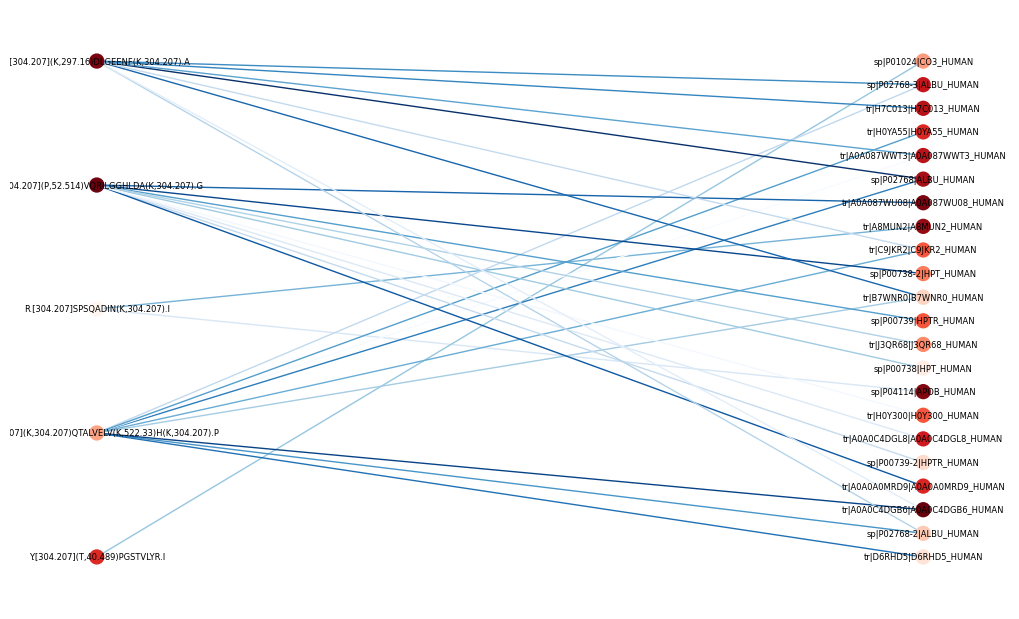

In [96]:
peptide_protein = list(zip(topk_peptides, topk_proteins))

# add peptide
G = nx.Graph()
for peptide in topk_peptides:
    G.add_node(peptide, bipartite=0)

# add protein
for protein_list in topk_proteins:
    for protein in protein_list:
        G.add_node(protein, bipartite=1)

# add edge
for peptide, protein_list in peptide_protein:
    for protein in protein_list:
        G.add_edge(peptide, protein)

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
cmap=plt.get_cmap('Reds')
edge_cmap=plt.get_cmap('Blues')

peptide_nodes = set(n for n, d in G.nodes(data=True) if d['bipartite']==0)
protein_nodes = set(G) - peptide_nodes

plt.figure(figsize=(10,6)) 
pos = nx.bipartite_layout(G, peptide_nodes)
nx.draw(G, pos, with_labels=True, node_size=100,font_size=6,edge_color=np.random.random(num_edges), 
        edge_cmap=plt.get_cmap('Blues'), 
        node_color=np.random.random(num_nodes),
        cmap=plt.get_cmap('Reds'))
plt.savefig("bigraph.png",dpi=300)
plt.show()

In [93]:
# Ref: this code is generated by GPT-4: https://chat.openai.com/?model=gpt-4
# Check whether the peptides are uniquely mapped to the proteins
peptide_counts = [len(set(protein_list)) for peptide, protein_list in peptide_protein]
unique_peptides = [peptide for peptide, count in zip(topk_peptides, peptide_counts) if count == 1]

print(f"Number of unique peptides: {len(unique_peptides)}")

# Check whether other peptides of the same proteins are also identified
protein_counts = [len(set([peptide for peptide, protein_list in peptide_protein if protein in protein_list])) for protein in set(sum(topk_proteins, []))]
proteins_with_multiple_peptides = [p for p, count in zip(set(sum(topk_proteins, [])), protein_counts) if count > 1]

print(f"Number of proteins with multiple peptides identified: {len(proteins_with_multiple_peptides)}")

peptide_counts = [len(set(protein_list)) for peptide, protein_list in peptide_protein]
unique_peptide_protein_mapping = [(peptide, protein_list[0]) for peptide, protein_list, count in zip(topk_peptides, topk_proteins, peptide_counts) if count == 1]

print('----------------------')
print('Peptide to Protein: ')
for peptide, protein in unique_peptide_protein_mapping:
    print(f"{peptide} → {protein}")

# First, let's flatten the list of proteins and count the occurrences of each protein
all_proteins = [protein for protein_list in topk_proteins for protein in protein_list]
protein_counts = {protein: all_proteins.count(protein) for protein in set(all_proteins)}

# Now, let's find proteins that only appear once, i.e., they have a unique peptide mapped to them
unique_protein_peptide_mapping = [(protein, peptide) for peptide, protein_list in peptide_protein for protein in protein_list if protein_counts[protein] == 1]

print('----------------------')
print('Protein to Peptide: ')
for protein, peptide in unique_protein_peptide_mapping:
    print(f"{protein} → {peptide}")

Number of unique peptides: 1
Number of proteins with multiple peptides identified: 7
----------------------
Peptide to Protein: 
Y.[304.207](T,40.489)PGSTVLYR.I → sp|P01024|CO3_HUMAN
----------------------
Protein to Peptide: 
sp|P04114|APOB_HUMAN → R.[304.207]SPSQADIN(K,304.207).I
tr|A8MUN2|A8MUN2_HUMAN → R.[304.207]SPSQADIN(K,304.207).I
sp|P01024|CO3_HUMAN → Y.[304.207](T,40.489)PGSTVLYR.I
tr|D6RHD5|D6RHD5_HUMAN → K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P
tr|H0YA55|H0YA55_HUMAN → K.[304.207](K,304.207)QTALVELV(K,522.33)H(K,304.207).P
sp|P00738-2|HPT_HUMAN → N.[304.207](P,52.514)VQRILGGHLDA(K,304.207).G
sp|P00738|HPT_HUMAN → N.[304.207](P,52.514)VQRILGGHLDA(K,304.207).G
sp|P00739-2|HPTR_HUMAN → N.[304.207](P,52.514)VQRILGGHLDA(K,304.207).G
sp|P00739|HPTR_HUMAN → N.[304.207](P,52.514)VQRILGGHLDA(K,304.207).G
tr|A0A087WU08|A0A087WU08_HUMAN → N.[304.207](P,52.514)VQRILGGHLDA(K,304.207).G
tr|A0A0A0MRD9|A0A0A0MRD9_HUMAN → N.[304.207](P,52.514)VQRILGGHLDA(K,304.207).G
tr|A0A0C4

## Assessment on peptide/variant-level differential abundance (todo)

## Assessment on protein-level differential abundance (todo)